In [1]:
import os
import numpy as np
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD
from tqdm import tqdm

/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 2080 Ti


In [3]:
IMAGES_PATH = "wg4bpm33hj-2/images"
MASKS_PATH = "wg4bpm33hj-2/masks"
WEIGHT_PATH = "task16"

EPOCHS = 200
BATCH_SIZE = 8
IMAGE_SIZE = 400
LR = 0.001
NUM_SAVE = 5
NK = 8

In [4]:
class CCAgTDataset(Dataset):
    def __init__(self, image_path: str, label_path: str, set_type="train", first_transform=None, sec_transform=None) -> None:
        super().__init__()
        self.first_transform = first_transform
        self.sec_transform = sec_transform
        self.images = []
        self.labels = []
        self.data = []
        self.split_ratio = {"train": (0.0, 0.7), "val": (0.7, 0.8), "test": (0.8, 1.0)}
        self.maxV = 7
        self.mask_ratio = 255 // self.maxV
        
        assert set_type in self.split_ratio.keys(), "dataset type error"
  
        for root, dirs, files in os.walk(image_path):
            for f in files:
                self.images.append(os.path.join(root, f))
                
        for root, dirs, files in os.walk(label_path):
            for f in files:
                self.labels.append(os.path.join(root, f))
                
        assert len(self.images) == len(self.labels), f"data length error, {len(self.images)}, {len(self.labels)}"
        
        for ele in zip(sorted(self.images), sorted(self.labels)):
            self.data.append(ele)
        
        shuffle(self.data)
        self.data = self.data[int(len(self.data)*self.split_ratio[set_type][0]) : int(len(self.data)*self.split_ratio[set_type][1])]
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, mask_path = self.data[index]

        #image = torch.from_numpy(np.array(Image.open(image_path), dtype=np.float64))
        image = Image.open(image_path)
        #mask =  Image.open(mask_path).convert("L")
        mask =  Image.open(mask_path)
        
        if self.first_transform is not None:
            image = self.first_transform(image)
            y = self.first_transform(mask)

        image = transforms.ToTensor()(image)
        y = np.array(y)
        y = torch.from_numpy(y)
        
        y = y.type(torch.LongTensor)
        
        return image, y


In [5]:
# y = np.random.randint(0, 8, (8, 1, 3, 3))
# z = torch.randint(0, 8, (8, 8, 3, 3)).float()
# #y = torch.clone(z)
# #print(y)
# n = np.zeros((8, 8, 3, 3))

# for i, row in enumerate(y):
#     for j, ele in enumerate(row):
#         print(ele)
#         n[ele][i][j] = 1
# print(n)

# sf = nn.Softmax(1)
# #print(sf(z))
# print(z[0])
# x = torch.argmax(z, axis=1).unsqueeze(1).float()
# print(x[0])

In [6]:
# image_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
#     ])
# label_transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))
#     ])
# trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", image_transform=image_transform, label_transform=label_transform)
# x, y = trainset[0]
# y = y.int()
# print(torch.max(y))
# print(torch.min(y))
# print(y.shape)
# print(x)

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [8]:
# net = UNet(in_channels=3, out_channels=8)
# ins = torch.randn(2, 3, 400 ,400)
# out = net(ins)
# print(out.shape)
# print(out)

In [9]:
def test_network():
    ins = torch.randn(2, 3, 800, 800).to(device)
    net = UNet().to(device)
    out = net(ins)
    print(out.shape)
    
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input, target, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)
    
def save_weight(name: str):
        torch.save(net.state_dict(), os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight"))

def load_weight(name: str):
    net.load_state_dict(torch.load(os.path.join(WEIGHT_PATH, f"checkpoint_{name}.weight")))


In [10]:
transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
    ]) 
trainset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "train", first_transform=transform)
trainLoader = DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

valset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "val", first_transform=transform)
valLoader = DataLoader(valset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)

net = UNet(3, 8).to(device)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=LR)
#optimizer = SGD(net.parameters(), lr=LR, momentum=0.9)
log = {"train_loss": [], "val_loss": []}

<ipython-input-10-c26103ad7be6>:2: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [11]:
trainset[0][0]

tensor([[[0.8314, 0.8510, 0.8588,  ..., 0.7765, 0.7843, 0.8000],
         [0.8275, 0.8431, 0.8510,  ..., 0.7961, 0.7882, 0.7882],
         [0.8275, 0.8392, 0.8471,  ..., 0.8039, 0.8000, 0.7804],
         ...,
         [0.8275, 0.8196, 0.8314,  ..., 0.8275, 0.8275, 0.8235],
         [0.8314, 0.8275, 0.8275,  ..., 0.8275, 0.8353, 0.8275],
         [0.8275, 0.8392, 0.8353,  ..., 0.8353, 0.8353, 0.8353]],

        [[0.8157, 0.8353, 0.8392,  ..., 0.7412, 0.7490, 0.7529],
         [0.8157, 0.8235, 0.8392,  ..., 0.7490, 0.7529, 0.7529],
         [0.8157, 0.8196, 0.8353,  ..., 0.7608, 0.7569, 0.7529],
         ...,
         [0.8118, 0.8078, 0.8039,  ..., 0.8118, 0.8235, 0.8275],
         [0.8196, 0.8157, 0.8157,  ..., 0.8118, 0.8196, 0.8235],
         [0.8157, 0.8118, 0.8196,  ..., 0.8118, 0.8196, 0.8196]],

        [[0.7804, 0.8000, 0.8275,  ..., 0.6824, 0.6902, 0.6980],
         [0.7882, 0.8000, 0.8196,  ..., 0.6863, 0.6863, 0.6863],
         [0.7961, 0.8039, 0.8078,  ..., 0.6902, 0.6863, 0.

In [12]:
def train():
    try:
        for eps in range(EPOCHS):
            net.train()
            print(f"{eps} epoch:")
            total_train_loss = 0
            total_val_loss = 0
            # train
            print("train~")
            for ins, labels in tqdm(trainLoader):
                ins_gpu = ins.to(device)
                labels_gpu = labels.long().squeeze(1).to(device)

                pred = net(ins_gpu)
                #pred = torch.argmax(pred, dim=1).unsqueeze(1).float()
                #print(pred)

                optimizer.zero_grad()
                loss = criterion(pred, labels_gpu)
                loss += dice_loss(F.softmax(pred, dim=1).float(), F.one_hot(labels_gpu, 8).permute(0, 3, 1, 2).float(), True)

                
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                #print(total_train_loss)

            # val
            print("val~")
            with torch.no_grad():
                net.eval()
                for ins, labels in tqdm(valLoader):
                    ins_gpu = ins.to(device)
                    labels_gpu = labels.long().squeeze(1).to(device)

                    pred = net(ins_gpu)
                    loss = criterion(pred, labels_gpu)
                    loss += dice_loss(F.softmax(pred, dim=1).float(), F.one_hot(labels_gpu, 8).permute(0, 3, 1, 2).float(), True)
                    total_val_loss += loss.item()
                    #total_val_loss += criterion(pred, labels_gpu).item()

            avg_train_loss = total_train_loss / len(trainLoader)
            avg_val_loss = total_val_loss / len(valLoader)

            if log["val_loss"] and avg_val_loss < np.min(log["val_loss"]):
                print("save best weight")
                save_weight("best")

            log["train_loss"].append(avg_train_loss)
            log["val_loss"].append(avg_val_loss)

            print(f"avg_train_loss: {avg_train_loss}, avg_val_loss: {avg_val_loss}")
            if eps and eps%NUM_SAVE == 0:
                save_weight(f"{eps}")
                train_loss = np.array(log["train_loss"])
                val_loss = np.array(log["val_loss"])
                np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
                np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
                
    except KeyboardInterrupt:
        print("interrupt")
        save_weight("interrupt")
        train_loss = np.array(log["train_loss"])
        val_loss = np.array(log["val_loss"])
        np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
        np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
        
    print("END")
    save_weight("END")
    train_loss = np.array(log["train_loss"])
    val_loss = np.array(log["val_loss"])
    np.save(f"{WEIGHT_PATH}/train_loss", train_loss)
    np.save(f"{WEIGHT_PATH}/val_loss", val_loss)
        

In [ ]:
train()

0 epoch:
train~


100%|██████████| 818/818 [09:30<00:00,  1.43it/s]


val~


100%|██████████| 117/117 [00:30<00:00,  3.88it/s]


avg_train_loss: 0.13853674180222753, avg_val_loss: 0.04278591357999378
1 epoch:
train~


100%|██████████| 818/818 [09:32<00:00,  1.43it/s]


val~


100%|██████████| 117/117 [00:29<00:00,  3.91it/s]


save best weight
avg_train_loss: 0.03797403323489144, avg_val_loss: 0.03695838946180466
2 epoch:
train~


100%|██████████| 818/818 [09:32<00:00,  1.43it/s]


val~


100%|██████████| 117/117 [00:30<00:00,  3.87it/s]


avg_train_loss: 0.03384473460241424, avg_val_loss: 0.03819139381377106
3 epoch:
train~


100%|██████████| 818/818 [09:33<00:00,  1.43it/s]


val~


100%|██████████| 117/117 [00:30<00:00,  3.83it/s]


save best weight
avg_train_loss: 0.030451005902528434, avg_val_loss: 0.03386809368036751
4 epoch:
train~


100%|██████████| 818/818 [09:35<00:00,  1.42it/s]


val~


100%|██████████| 117/117 [00:30<00:00,  3.88it/s]


save best weight
avg_train_loss: 0.027114422982194276, avg_val_loss: 0.027816891339886136
5 epoch:
train~


 94%|█████████▍| 768/818 [08:58<00:34,  1.43it/s]

In [18]:
def make_image(mask, threshold=0.2):
    ch, h, w = mask.size()
    img = np.zeros((h, w, 1))
    for idx, channel in enumerate(mask):
        img[:][channel>threshold] = idx
#         for i, row in enumerate(channel):
#             for j, ele in enumerate(row):
#                 if ele > threshold:
#                     img[i][j] = idx
                    
    print(np.max(img))
    print(np.min(img))
    print(img.shape)

def show_image(ins, gts, preds):
    print(torch.max(preds))
    print(torch.min(preds))
    predictions = torch.nn.functional.softmax(preds, dim=1)
    pred_labels = torch.argmax(predictions, dim=1) 
    pred_labels = pred_labels.float()
    batch = ins.size()[0]
    fig, axs = plt.subplots(3, batch, constrained_layout=True, figsize=(100, 100))
    for idx, (i, g, p) in enumerate(zip(ins, gts, pred_labels)):
        #print(i.shape, g.shape, p.shape)
        axs[0, idx].imshow(i.permute(1, 2, 0))
        axs[1, idx].imshow(g)
        axs[2, idx].imshow(p)
    
    plt.show()
        

def test():
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
    ]) 
    
    testset = CCAgTDataset(IMAGES_PATH, MASKS_PATH, "test", first_transform=transform)
    testLoader = DataLoader(testset, batch_size=BATCH_SIZE, num_workers=NK, shuffle=True)
    #net = UNet(3, 8).to(device)
    #load_weight("best")
    
    with torch.no_grad():
        net.eval()
        for ins, labels in tqdm(testLoader):
            ins_gpu = ins.to(device)
            labels_gpu = labels.long().squeeze(1).to(device)

            pred = net(ins_gpu)
            #print(pred.shape, labels_gpu.shape)
            test_loss = criterion(pred, labels_gpu).item()
            print("test loss, ", test_loss)
            show_image(ins, labels, pred.cpu())
            break
            

<ipython-input-18-66c1e6bb60b6>:34: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
  0%|          | 0/234 [00:00<?, ?it/s]

test loss,  0.014403254725039005
tensor(26.6042)
tensor(-64.1969)


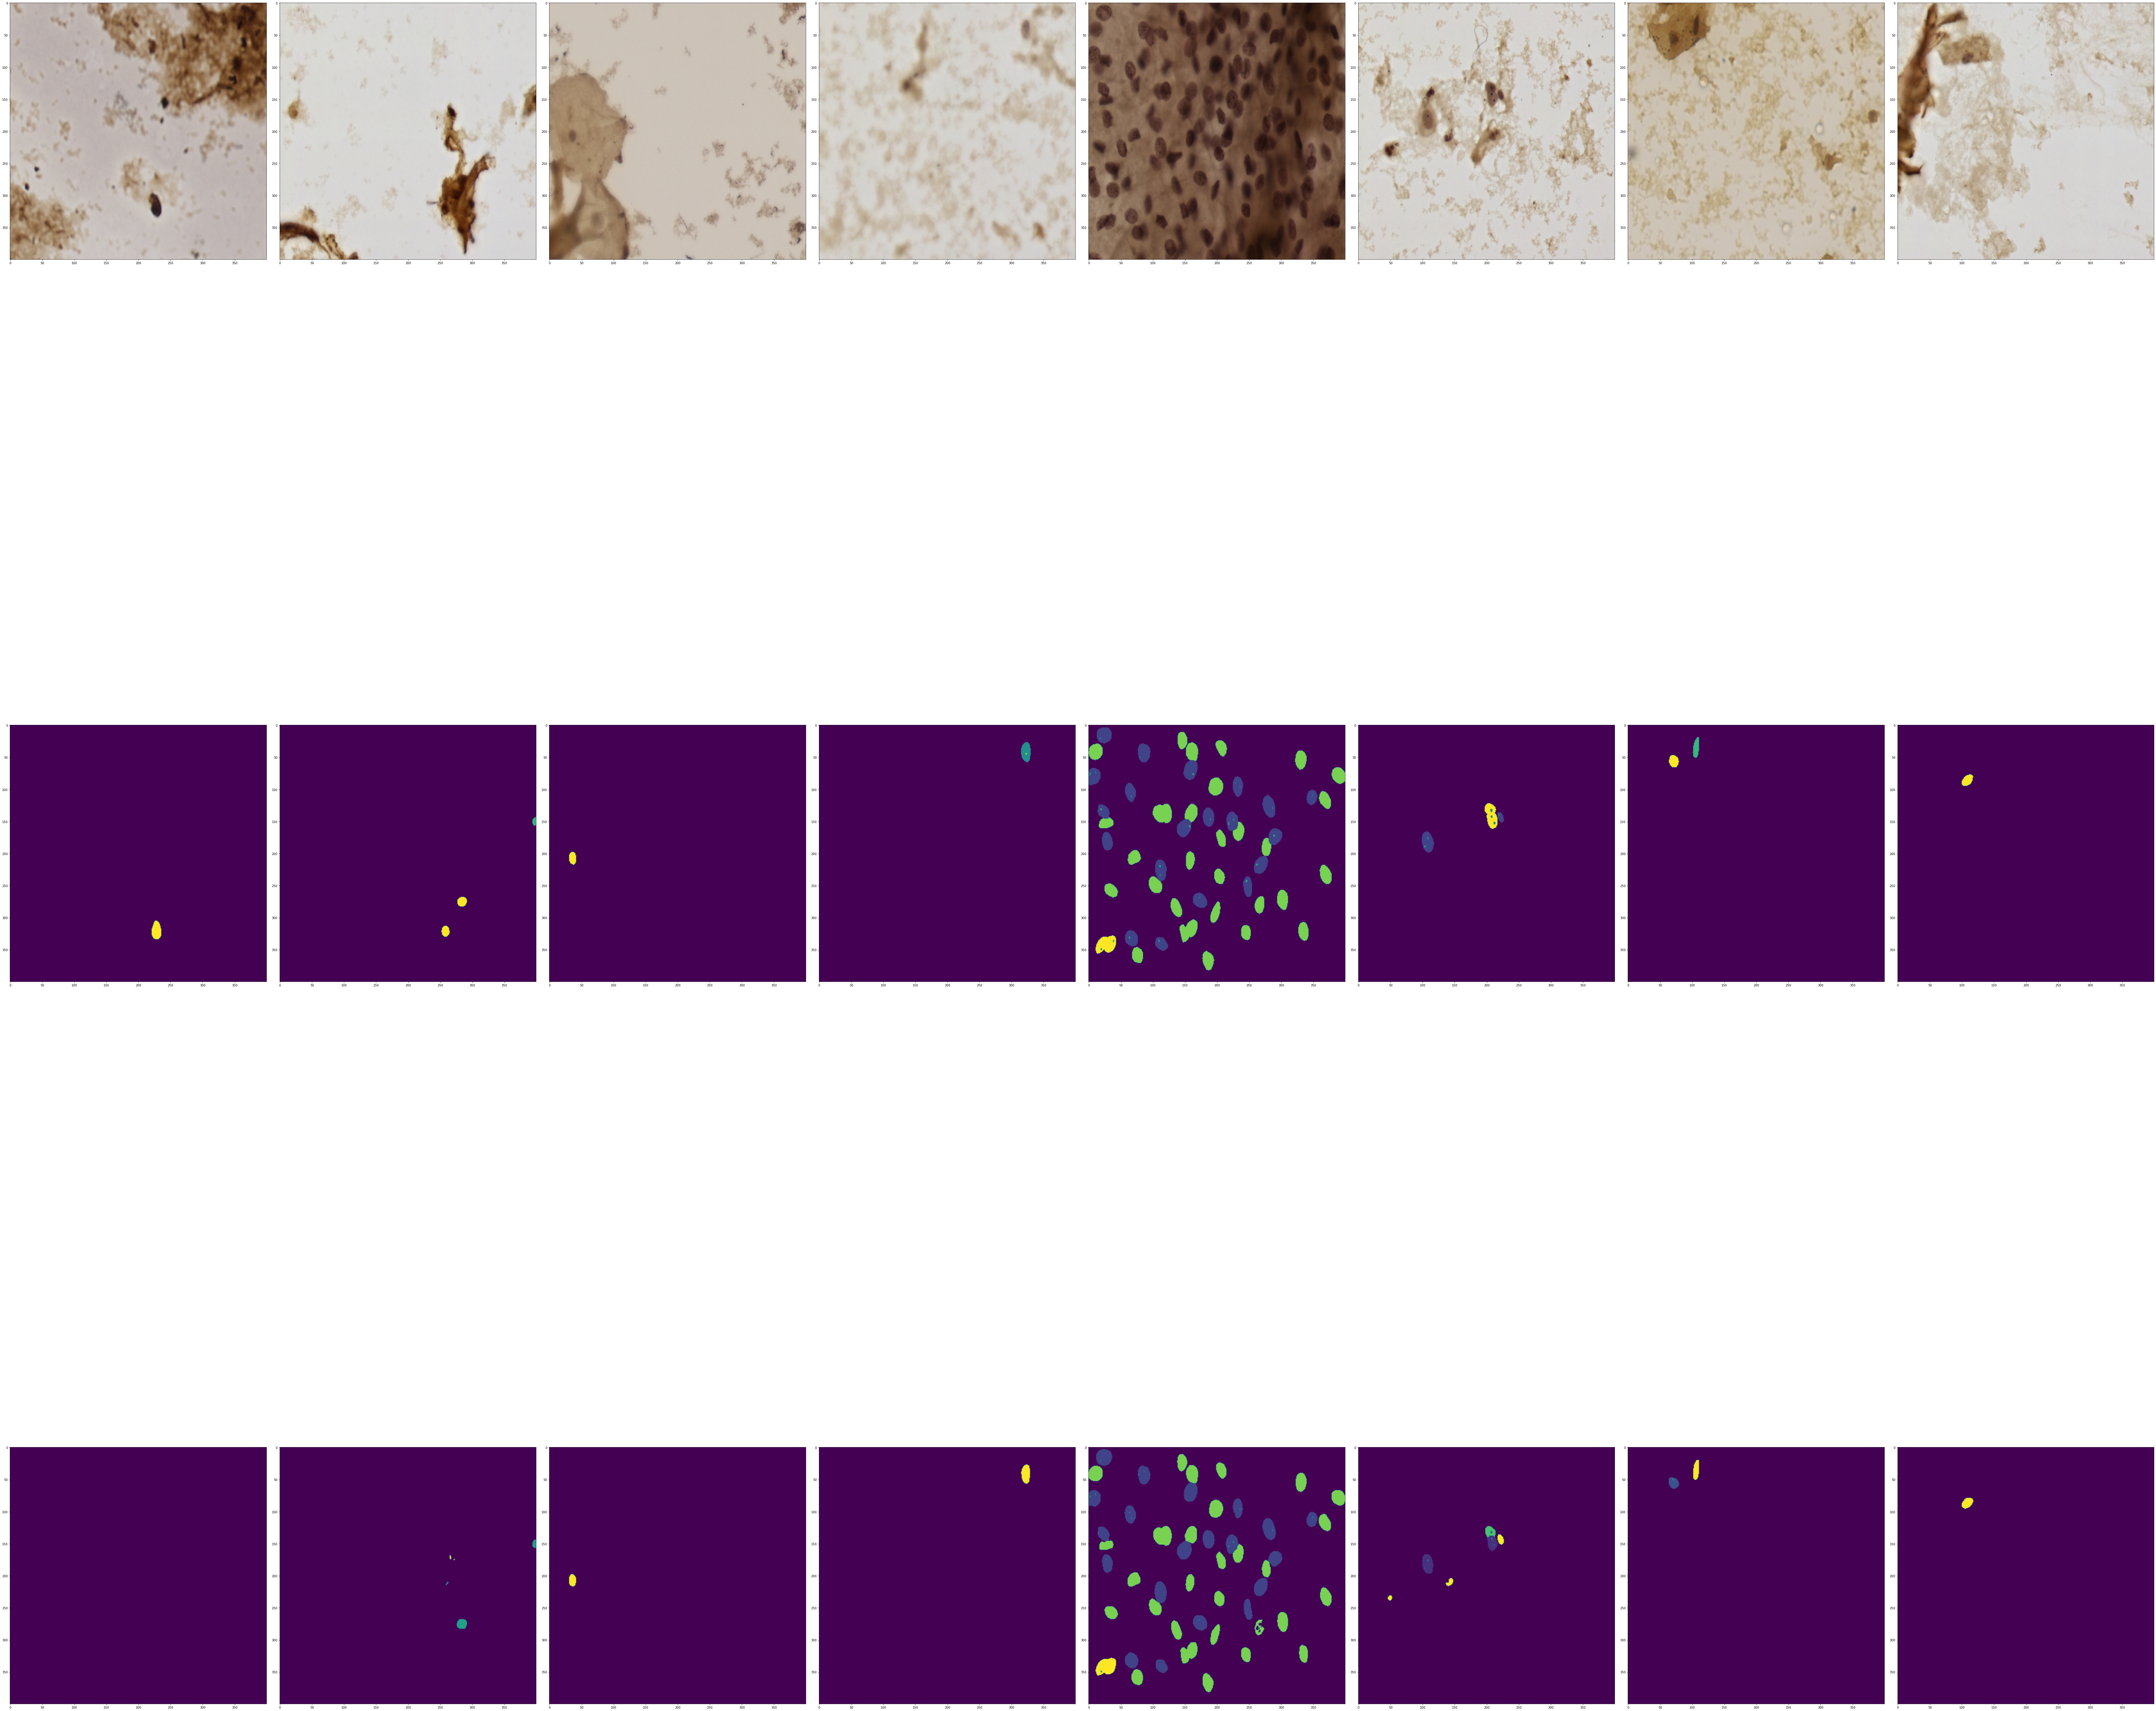

  0%|          | 0/234 [00:12<?, ?it/s]


In [19]:
test()

In [ ]:
train_loss = np.load(f"{WEIGHT_PATH}/train_loss.npy")
val_loss = np.load(f"{WEIGHT_PATH}/val_loss.npy")

plt.plot(train_loss, color="blue")
plt.plot(val_loss, color="red")
plt.show()

In [ ]:
def pixel_accuracy(predictions, labels):
    correct = (predictions == labels).float()
    pacc = correct.sum() / correct.numel()
    return pacc

def class_pixel_accuracy(predictions, labels, num_classes):
    correct = (predictions == labels).float()
    class_correct = [correct[labels == i].sum() for i in range(num_classes)]
    class_total = [labels[labels == i].numel() for i in range(num_classes)]
    class_acc = [c / t for c, t in zip(class_correct, class_total)]
    return sum(class_acc) / num_classes

